- [Generative Adversarial Networks](https://arxiv.org/abs/1406.2661)
- [NIPS 2016 Tutorial:
Generative Adversarial Networks](https://arxiv.org/pdf/1701.00160.pdf)
- [image source](https://xiaohongliu.ca/post/gan/)

## Library

In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import numpy as np
import math
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms.functional import to_pil_image
from torchvision import datasets
from torchvision import models
from torchvision import transforms
from torch.utils.data import DataLoader

In [3]:
torch.__version__    

'1.13.1+cu117'

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.manual_seed(2023)

## Hyperparameters

In [6]:
"""
학습에 사용될 hyperparameter 값들을 넣을 class를 정의합니다.
"""
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [7]:
"""
GAN model 학습에 사용되는 결과 이미지 저장 경로, 에포크 수, 모델 입력 이미지 크기 등을 정의합니다.
"""
config = AttrDict()
config.data_path = 'data/resource/' 
config.save_path = 'save/DELiGAN_64/'
#config.dataset = 'CIFAR10' #CIFAR10 어떠한 데이터셋을 사용하는지#
config.dataset = 'emoji'
config.n_epoch = 200

config.nz = 100
config.ngf = 128 # generator oonv filter
config.ndf = 128 # discriminator oonv fillter


config.log_interval =70 # loss 출력
config.save_interval = 10  # 이미지 출력
config.batch_size = 200
config.learning_rate = 0.001
config.b1 = 0.5
config.b2 = 0.999
config.img_shape = (3, 64, 64) # c, w, h
config.latent_size = 100 # random noise size
"""
모델 입력 이미지에 수행할 normalization과 모델 생성 결과 이미지에 수행할 denormalization을 정의합니다.
"""
config.augmentation = transforms.Compose([
                        transforms.Resize((config.img_shape[1], config.img_shape[2])), #resize
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.5], std=[0.5]) #normalization
                      ])
config.denormalize = lambda x: x*0.5+0.5 #denormalization 위의 단계 reverse , 원래의 이미지를 보기 위해 수행함

config.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #cuda에 올리기

In [8]:
#지정된 경로의 데이터셋 가져오기 및 저장
if not os.path.isdir(config.data_path):
    os.makedirs(config.data_path)
if not os.path.isdir(os.path.join(config.save_path, config.dataset)):
    os.makedirs(os.path.join(config.save_path, config.dataset))

In [9]:
config.device

device(type='cuda')

## Data load

In [10]:
"""
MNIST와 CIFAR-10은 torchvision 라이브러리에서 제공하여 아래와 같이 사용할 수 있습니다.
"""
                                 
if config.dataset == 'CIFAR10': 
    train_dataset = datasets.CIFAR10(config.data_path,
                                       train=True,
                                       download=True,
                                       transform=config.augmentation
                                     )
elif config.dataset == 'emoji': 
    train_dataset = datasets.ImageFolder(config.data_path,
                                         transform=config.augmentation
                                     )

print(config.dataset)
    
"""
training set을 Dataloader에 넣습니다. 
"""
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers = 2)
print(train_dataset)

emoji
Dataset ImageFolder
    Number of datapoints: 13824
    Root location: data/resource/
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )


In [11]:
len(train_dataset)

13824

In [12]:
img, label = train_dataset[0]

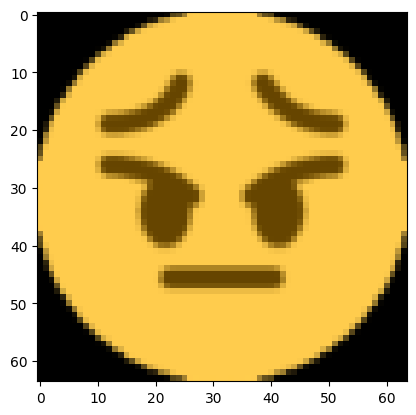

In [13]:
plt.imshow(to_pil_image(0.5*img+0.5))

## custom data

로컬 디렉토리 image 가져오기

In [14]:
import urllib.request
import zipfile
import glob

In [15]:
data_path = ''
glob.glob('data/resource/emoji/*')[:20]

[]

In [16]:
train_loader

## GAN model

In [17]:
config.img_shape

(3, 64, 64)

In [18]:
"""
 일반적으로, GAN에서는 loss가 Discriminator에서부터 Generator로 흐를 때 생길 수 있는 
 vanishing gradient 현상을 완화하기 위해 Leaky ReLU를 많이 사용합니다. 
"""
class Generator(nn.Module): # 입력으로 noise를 받음
    def __init__(self, config):
        super().__init__()

        mu = 2 * torch.rand(config.latent_size) - 1
        mu.requires_grad = True
        self.mu = nn.Parameter(mu)
        sigma = 0.2 * torch.ones(config.latent_size)
        sigma.requires_grad = True
        self.sigma = nn.Parameter(sigma)
        
        
        self.dconv1 = nn.ConvTranspose2d(config.latent_size, config.ngf*8, 4, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(config.ngf*8)
        #62
            
        self.dconv2 = nn.ConvTranspose2d(config.ngf*8, config.ngf*4, 4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(config.ngf*4)
        #15   
            
        self.dconv3 = nn.ConvTranspose2d(config.ngf*4, config.ngf*2, 4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(config.ngf*2)
            
        self.dconv4 = nn.ConvTranspose2d(config.ngf*2, config.ngf,4,stride=2,padding=1)
        self.bn4 = nn.BatchNorm2d(config.ngf)
            
        self.dconv5 = nn.ConvTranspose2d(config.ngf, config.img_shape[0], 4,stride=2, padding=1)
        
    def forward(self, z):
        #print(z)
        idx = torch.randint(0, self.mu.size(0), z.size())
        #print(idx)
        z = z * self.sigma[idx] + self.mu[idx]
        #print(z)
        z = z.view(-1, 100, 1, 1)
        #print(z)
        
        x = F.leaky_relu(self.bn1(self.dconv1(z)), 0.2)
        x = F.leaky_relu(self.bn2(self.dconv2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.dconv3(x)), 0.2)
        x = F.leaky_relu(self.bn4(self.dconv4(x)), 0.2)
        x = torch.tanh(self.dconv5(x))
        #img = img.reshape(img.shape[0], *config.img_shape)
        return x

In [19]:
class Discriminator(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.conv1 = nn.Conv2d(config.img_shape[0],config.ndf,4,stride=2,padding=1,bias=False)
        self.conv2 = nn.Conv2d(config.ndf,config.ndf*2,4,stride=2,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(config.ndf*2)
        
        self.conv3 = nn.Conv2d(config.ndf*2, config.ndf*4,4,stride=2,padding=1,bias=False)
        self.bn3 = nn.BatchNorm2d(config.ndf*4)
        
        self.conv4 = nn.Conv2d(config.ndf*4,config.ndf*8,4,stride=2,padding=1,bias=False)
        self.bn4 = nn.BatchNorm2d(config.ndf*8)
        
        self.conv5 = nn.Conv2d(config.ndf*8,1,4,stride=1,padding=0,bias=False)

    def forward(self,x):
        x = F.leaky_relu(self.conv1(x),0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)),0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)),0.2)
        x = F.leaky_relu(self.bn4(self.conv4(x)),0.2)
        x = torch.sigmoid(self.conv5(x))
        return x.view(-1,1)

#### Binary Cross Entropy loss between the target and the input probabilities

- [torch.nn.BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)

In [20]:
"""
binary cross entropy loss를 사용하여 adversarial loss를 구현합니다.
"""
criterion = nn.BCELoss()

"""
Generator와 Discriminator를 각각 정의하고, 상응하는 optimizer도 함께 정의합니다.
"""
generator = Generator(config).to(config.device)
discriminator = Discriminator(config).to(config.device)

optimizer_g = torch.optim.Adam(generator.parameters(), lr=config.learning_rate, betas=(config.b1, config.b2))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=config.learning_rate, betas=(config.b1, config.b2))

## Training

In [ ]:
"""
Generator와 Discriminator를 번갈아 학습합니다.
"""
g_loss_list = []
d_loss_list = []
for epoch in tqdm(range(config.n_epoch)):
    for i, (real_img, _) in enumerate(train_loader):
        # 실제 이미지
        real_img = real_img.to(config.device)
        
        optimizer_d.zero_grad()
        
        #label
        valid_label = torch.ones((real_img.shape[0], 1), device=config.device, dtype=torch.float32)
        fake_label = torch.zeros((real_img.shape[0], 1), device=config.device, dtype=torch.float32)
        
        # ====================================================#
        #                Train Discriminator                  #
        # ====================================================#

        
        #latent 생성
        z = torch.randn((real_img.shape[0], config.latent_size,1,1), device=config.device, dtype=torch.float32)
        gen_img = generator(z)
        

        ## D loss
        real_loss = criterion(discriminator(real_img), valid_label)
        # G_loss
        fake_loss = criterion(discriminator(gen_img.detach()), fake_label) # detach generator는 가중치 업데이트 안함

        d_loss = (real_loss + fake_loss) * 0.5

        
        d_loss.backward() # 여기서 grediant가 업데이트 안됨
        optimizer_d.step()
   
            

        
        # ====================================================#
        #                   Train Generator                   #
        # ====================================================#


        """
        Generator가 Discriminator를 속일 수 있는지 loss를 계산합니다.
        """

        g_loss = criterion(discriminator(gen_img), valid_label) #valid_label로 하여 generator를 학습하게 함
   
        
        """
        Generator를 업데이트합니다.
        """
        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()
    
  
        if (i+1) % config.log_interval == 0:
            g_loss_list.append(g_loss.item())
            d_loss_list.append(d_loss.item())
            print('Epoch [{}/{}] Batch [{}/{}] Discriminator loss: {:.4f} Generator loss: {:.4f}'.format(
                epoch+1,
                config.n_epoch,
                i+1,
                len(train_loader),
                g_loss.item(),
                d_loss.item()
            ))
                
            
    if (epoch+1) % config.save_interval == 0:
        save_path = os.path.join(config.save_path, config.dataset, 'epoch_[{0:-03d}]_.png'.format(
            epoch+1
        ))
        gen_img = config.denormalize(gen_img)
        torchvision.utils.save_image(gen_img.data[:16], save_path, nrow=4, normalize=True)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200] Batch [70/70] Discriminator loss: 4.3071 Generator loss: 0.1147
Epoch [2/200] Batch [70/70] Discriminator loss: 7.5536 Generator loss: 0.0049
Epoch [3/200] Batch [70/70] Discriminator loss: 4.5067 Generator loss: 0.0270
Epoch [4/200] Batch [70/70] Discriminator loss: 27.5924 Generator loss: 2.6191
Epoch [5/200] Batch [70/70] Discriminator loss: 15.3240 Generator loss: 0.0003
Epoch [6/200] Batch [70/70] Discriminator loss: 7.7302 Generator loss: 0.0101
Epoch [7/200] Batch [70/70] Discriminator loss: 9.6036 Generator loss: 1.4095
Epoch [8/200] Batch [70/70] Discriminator loss: 6.4758 Generator loss: 0.2428
Epoch [9/200] Batch [70/70] Discriminator loss: 6.9509 Generator loss: 1.3753
Epoch [10/200] Batch [70/70] Discriminator loss: 9.7883 Generator loss: 0.1612
Epoch [11/200] Batch [70/70] Discriminator loss: 13.3447 Generator loss: 0.8676
Epoch [12/200] Batch [70/70] Discriminator loss: 8.1909 Generator loss: 0.1057
Epoch [13/200] Batch [70/70] Discriminator loss: 6.4655 Ge

Epoch [105/200] Batch [70/70] Discriminator loss: 7.1857 Generator loss: 0.0116
Epoch [106/200] Batch [70/70] Discriminator loss: 10.1031 Generator loss: 0.0247
Epoch [107/200] Batch [70/70] Discriminator loss: 12.5157 Generator loss: 0.0005
Epoch [108/200] Batch [70/70] Discriminator loss: 0.5058 Generator loss: 0.2065
Epoch [109/200] Batch [70/70] Discriminator loss: 6.4644 Generator loss: 0.0254
Epoch [110/200] Batch [70/70] Discriminator loss: 13.5487 Generator loss: 0.0053
Epoch [111/200] Batch [70/70] Discriminator loss: 11.0934 Generator loss: 0.0082
Epoch [112/200] Batch [70/70] Discriminator loss: 4.8348 Generator loss: 0.0256
Epoch [113/200] Batch [70/70] Discriminator loss: 6.3043 Generator loss: 0.0135
Epoch [114/200] Batch [70/70] Discriminator loss: 1.0269 Generator loss: 0.0753
Epoch [115/200] Batch [70/70] Discriminator loss: 8.3743 Generator loss: 0.0126
Epoch [116/200] Batch [70/70] Discriminator loss: 2.8136 Generator loss: 0.1225
Epoch [117/200] Batch [70/70] Discri

In [ ]:
plt.title('GAN training loss on {} data'.format(config.dataset))
plt.plot(g_loss_list, label='generator loss')
plt.plot(d_loss_1_list, label='discriminator_1 loss')
plt.plot(d_loss_2_list, label='discriminator_2 loss')
plt.legend()
plt.show()

## Qualitative results

In [ ]:
save_path = os.path.join(config.save_path, config.dataset)
for image_path in os.listdir(save_path):
    if image_path.endswith('.png'):
        plt.figure(figsize=(5,5))
        image = Image.open(os.path.join(save_path, image_path))
        plt.title(image_path)
        plt.imshow(image)
        plt.show()